# Benchmark

This notebook runs an (artificial) benchmark to show how the computational cost of UMAP and the lens types varies with a dataset's size and several parameters. The results indicate how the lens types scale to larger UMAP models. This benchmark is not designed to reflect realistic data. Instead, random data containing 5 classes is generated using sklearn.

In [2]:
# Data
import time
from itertools import product
from datetime import datetime, timedelta
from sklearn.datasets import make_classification, make_blobs

# UMAP
from umap import UMAP
import lensed_umap as lu

Some numba code paths in UMAP and lensed UMAP only compile once called. We trigger that compilation here, to make sure it does not affect the performance sweep.

In [2]:
X, _ = make_classification()
lens, _ = make_blobs()

projector = UMAP(force_approximation_algorithm=True).fit(X)
_ = lu.apply_lens(projector, lens[:, 0])
_ = lu.apply_mask(projector, UMAP().fit(lens))
_ = lu.apply_local_mask(projector, lens)

## Implement sweep functionality

These cells implement the parameter sweep that records the compute, apply, and embed time for UMAP and the lens types. Here, the `compute time` reflects the time taken to build a UMAP model, both for the initial model and the mask-model used by the global mask. The `apply time` reflects the time required to filter edges from the original UMAP model based on the lens. Finally, `embed time` captures how long it takes to update the embedding. We also record how many edges remain after the lens is applied to compare the lens' strengths. Several parameters are varied so their influence can be investigated. The process boils down to generating 5 datasets and constructing a umap model given a number of neighbours $k$. Then, each lens is aplied with the given settings to each of the UMAP models. By varying both the number of data points and UMAP's number of neighbours $k$, we can isolate their influece on the run times.

In [3]:
params = {
    'n_repeats': 5,
    'data': {
        'sizes': [100, 1000, 10000, 100000],
    },
    'umap': {
        'n_neighbors': [10, 20, 40, 80],
    },
    'global_lens': {
        'strategies': ['regular', 'balanced'],
        'resolutions': [3, 6, 12, 24],
    },
    'global_mask': {
        'n_neighbors': [20, 40, 80, 160],
    },
    'local_mask': {
        'n_neighbors': [5, 10, 20, 40],
    },
}

In [4]:
def time_task(task, *args, **kwargs):
    """Outputs compute time in seconds."""
    start_time = time.perf_counter()
    output = task(*args, **kwargs)
    end_time = time.perf_counter()
    return end_time - start_time, output


def num_edges(projector):
    """Access the number of edges in the umap model."""
    return len(projector.graph_.data)


def build_umap(data, n_neighbors):
    """Construct UMAP model without embedding it."""
    return UMAP(
        n_neighbors=n_neighbors,
        transform_mode="graph",
    ).fit(data)


def write_line(file, *values):
    """Writes given values as csv line."""
    file.write(",".join([str(v) for v in values]) + "\n")


def generate_data(size):
    """Generates dataset and lens values."""
    (X, y_data) = make_classification(
        n_samples=size,
        n_features=20,
        n_classes=5,
        n_clusters_per_class=2,
        n_informative=10,
        n_redundant=5,
        n_repeated=0,
    )
    (lens, y_lens) = make_blobs(n_samples=size, n_features=1)
    return X, lens


def run_umap(X, n_points, n_neighbors, umap_file=None, **params):
    """Evaluates & stores UMAP compute times."""
    build_time, projector = time_task(build_umap, X, n_neighbors)
    embed_time, projector = time_task(lu.embed_graph, projector)
    write_line(
        umap_file,
        params["repeat"],
        n_points,
        n_neighbors,
        build_time,
        -1,
        embed_time,
        num_edges(projector),
    )
    return projector


def run_global_lens(projector, lens, global_lens=None, global_lens_file=None, **params):
    """Evaluates & stores global lens compute times."""
    for strategy, resolution in product(*global_lens.values()):
        apply_time, lensed_projector = time_task(
            lu.apply_lens,
            projector,
            lens[:, 0],
            discretization=strategy,
            resolution=resolution,
            skip_embedding=True,
        )
        lensed_projector.embedding_ = projector.embedding_
        embed_time, lensed_projector = time_task(lu.embed_graph, lensed_projector)
        write_line(
            global_lens_file,
            params["repeat"],
            params["n_points"],
            params["n_neighbors"],
            strategy,
            resolution,
            -1,
            apply_time,
            embed_time,
            num_edges(lensed_projector),
        )


def run_global_mask(projector, lens, global_mask=None, global_mask_file=None, **params):
    """Evaluates & stores global mask compute times."""
    for n_neighbors in global_mask["n_neighbors"]:
        if n_neighbors >= lens.shape[0]:
            continue
        build_time, masker = time_task(build_umap, lens, n_neighbors)
        apply_time, lensed_projector = time_task(
            lu.apply_mask, projector, masker, skip_embedding=True
        )
        lensed_projector.embedding_ = projector.embedding_
        embed_time, lensed_projector = time_task(lu.embed_graph, lensed_projector)
        write_line(
            global_mask_file,
            params["repeat"],
            params["n_points"],
            params["n_neighbors"],
            n_neighbors,
            build_time,
            apply_time,
            embed_time,
            num_edges(lensed_projector),
        )


def run_local_mask(projector, lens, local_mask=None, local_mask_file=None, **params):
    """Evaluates & stores local mask compute times."""
    for n_neighbors in local_mask["n_neighbors"]:
        if n_neighbors >= params["n_neighbors"]:
            continue
        apply_time, lensed_projector = time_task(
            lu.apply_local_mask,
            projector,
            lens,
            n_neighbors=n_neighbors,
            skip_embedding=True,
        )
        lensed_projector.embedding_ = projector.embedding_
        embed_time, lensed_projector = time_task(lu.embed_graph, lensed_projector)
        write_line(
            local_mask_file,
            params["repeat"],
            params["n_points"],
            params["n_neighbors"],
            n_neighbors,
            -1,
            apply_time,
            embed_time,
            num_edges(lensed_projector),
        )


def run_sizes_and_neighbors(data=None, umap=None, **params):
    for n_points in data["sizes"]:
        print(f"   evaluating {n_points} points")
        # Reusing dataset enables comparison accross num neighbors
        # at some decrease to generality, but we don't assume this
        # data represents real-world data anyway...
        X, lens = generate_data(n_points)
        for n_neighbors in umap["n_neighbors"]:
            projector = run_umap(X, n_points, n_neighbors, **params)
            run_global_lens(
                projector, lens, n_points=n_points, n_neighbors=n_neighbors, **params
            )
            run_global_mask(
                projector, lens, n_points=n_points, n_neighbors=n_neighbors, **params
            )
            run_local_mask(
                projector, lens, n_points=n_points, n_neighbors=n_neighbors, **params
            )


def run_repeats(n_repeats, **params):
    """Logs when repeats starts and estimates remaining run time."""
    prev_start = None
    durations = []

    for i in range(n_repeats):
        now = datetime.now()
        print(f'Starting repeat {i} at {now.strftime("%H:%M:%S")}')
        if prev_start:
            durations.append(now - prev_start)
            avg_duration = sum(durations, timedelta(0)) / len(durations)
            time_remaining = (n_repeats - i) * avg_duration
            print(f"   estimate time remaining: {time_remaining}")
        prev_start = now

        # Run all settings for this repeat
        run_sizes_and_neighbors(repeat=i, **params)

    now = datetime.now()
    print(f'Sweep finised at {now.strftime("%H:%M:%S")}')


def init_file(label, now, params):
    """Constructs a .csv file with column header to write values in."""
    name = f'./data/generated/benchmark_{label}_{now.strftime("%Y_%m_%d_%H_%M_%S")}.csv'
    base_header = ["repeat", "n_points"]
    if label != "umap":
        base_header.append("n_neighbors")
    method_header = [*params[label].keys()]
    measurement_header = ["compute_time", "apply_time", "embed_time", "n_edges"]

    handle = open(name, "w")
    handle.write(",".join(base_header + method_header + measurement_header) + "\n")
    return handle


def main(params):
    """Creates output files"""
    # Create files
    now = datetime.now()
    umap_file = init_file("umap", now, params)
    global_lens_file = init_file("global_lens", now, params)
    global_mask_file = init_file("global_mask", now, params)
    local_mask_file = init_file("local_mask", now, params)

    # Actual sweep
    run_repeats(
        umap_file=umap_file,
        global_lens_file=global_lens_file,
        global_mask_file=global_mask_file,
        local_mask_file=local_mask_file,
        **params,
    )

    # Close handles
    umap_file.close()
    global_lens_file.close()
    global_mask_file.close()
    local_mask_file.close()

The cell below runs the complete sweep. Time remaining is estimated once the first complete repeat finishes. The full sweep took about 2 hours on our machine. (The loops can be refactored to pre-compute each dataset's nearest neighbours once to speed up the process if UMAP's compute time is not of interest.)

In [5]:
main(params)

Starting repeat 0 at 17:25:42
   evaluating 100 points
   evaluating 1000 points
   evaluating 10000 points
   evaluating 100000 points
Starting repeat 1 at 17:45:48
   estimate time remaining: 1:20:21.658436
   evaluating 100 points
   evaluating 1000 points
   evaluating 10000 points
   evaluating 100000 points
Starting repeat 2 at 18:06:09
   estimate time remaining: 1:00:40.090704
   evaluating 100 points
   evaluating 1000 points
   evaluating 10000 points
   evaluating 100000 points
Starting repeat 3 at 18:30:33
   estimate time remaining: 0:43:13.903960
   evaluating 100 points
   evaluating 1000 points
   evaluating 10000 points
   evaluating 100000 points
Starting repeat 4 at 18:59:16
   estimate time remaining: 0:23:23.451917
   evaluating 100 points
   evaluating 1000 points
   evaluating 10000 points
   evaluating 100000 points
Sweep finised at 19:32:17


## The Results
In this section, the parameter sweep data is plotted and analysed to determine how the lens-type's run times behave given a UMAP models size (points and edges), and their parameters. First, we load the plotting libraries and disable future warnings.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from _plotting import *
configure_matplotlib()

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

The data was written to different files because each lens type has different parameters. We concatenate the data files and leave the irrelevant columns empty. In addition, we perform some processing: 

- columns are renamed to be singular and use an `_` instead of a space.
- numerical lens parameters are converted to be a string so they can be used as categories.
- the total time, and total time excluding embedding are computed from the individual time measurements.
- negative values are replaced with NaN as they indicate irrelevant / missing values. For example, the global lens does not have a compute-step (at least not one that is measureable as a distinct step in the current implementation).

In [4]:
def load_data():
    # Load files
    df = pd.concat([
        pd.read_csv(path).astype({
            'n_neighbors': 'str', 
            **{param: 'str' for param in params}
        }).assign(algorithm=algorithm)
        for algorithm, path, params in [
            ('umap', './data/generated/benchmark_umap_2024_02_02_17_25_42.csv', []),
            ('global_lens', './data/generated/benchmark_global_lens_2024_02_02_17_25_42.csv', ['resolutions', 'strategies']),
            ('global_mask', './data/generated/benchmark_global_mask_2024_02_02_17_25_42.csv', ['n_neighbors.1']),
            ('local_mask', './data/generated/benchmark_local_mask_2024_02_02_17_25_42.csv', ['n_neighbors.1'])
        ]
    ])

    # Change column names & types
    df = df.mask(lambda x: x == -1).rename(columns={
        'n_neighbors.1': 'n_mask_neighbors',
        'resolutions': 'resolution',
        'strategies': 'strategy'
    })
    
    # Add columns
    df['non_embed_time'] = df.compute_time.fillna(0) + df.apply_time.fillna(0)
    df['total_time'] = df.non_embed_time + df.embed_time
    andims = ['algorithm', 'n_points', 'n_neighbors', 'strategy', 'resolution', 'n_mask_neighbors', 'repeat']
    vdims = ['total_time', 'compute_time', 'apply_time', 'embed_time', 'non_embed_time', 'n_edges']
    return df[andims + vdims]

Here, we actually load the data and separate the lens values from UMAP's values so we can join them later to access the UMAP model's edge count.

In [5]:
df = load_data()
id_cols = ['n_points', 'n_neighbors', 'repeat']
udf = df.query('algorithm=="umap"').set_index(id_cols)['n_edges']

We limit our discussion of the lens type's scaling behaviour to the `apply time`. This step is not the computational bottleneck. Updating the embedding takes orders of magnitude more time and scales with the output size rather than the input size (from the lenses perspective). Computing a mask model (for the global mask) is also more expensive. This cost scales with the number of data points and neighbours considered.

First, we define several parameters specifying the figure's sizes and padding. These are tuned so the resulting images fits precisely in our manuscript. See `help(subplot_fractions)` for an explanation of our plotting workflow.

In [6]:
print(subplot_fractions(3, 1))
base_width = 2.25073
with_bar_width = 2.65215
title_padding = 0.9
bottom_padding = 0.2
height = base_width * 0.618 / (title_padding - bottom_padding)
time_range = [0.95 * df.apply_time.min(), 1.05 * df.apply_time.max()]

(0.3148148148148148, 0.3703703703703704)


Below, we plot a regression line (with 95% confidence interval) indicating how the global lens' apply time scales given the input model's edge count. A line is fitted for each dataset size separately, as is visible by the distinct line segments. Generally, we see the global lens scales with the input edge count, rather than the number of data points. This finding matches our computational analysis.

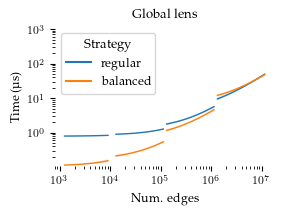

In [7]:
fig = plt.figure(figsize=(with_bar_width, height))
plt.subplots_adjust(0.02 + 0.15, bottom_padding, 1, title_padding)
gldf = df.query('algorithm=="global_lens"').join(udf, on=id_cols, rsuffix='_umap')
gldf.apply_time *= 1000
for n in [100, 1000, 10000, 100000]:
    for i, s in enumerate(['regular', 'balanced']):
        sns.regplot(
            gldf.query(f"n_points=={n} & strategy=='{s}'"), 
            x='n_edges_umap', 
            y='apply_time', 
            ci=95, 
            units='repeat',
            color=f'C{i}', 
            line_kws={'linewidth': 1},
            scatter=False
        )
# xs = np.linspace(1e3, 1e7, 500)
# for a in [5, 50, 500]:
    # plt.plot(xs, [time_range[0] * 1000 + a / 1e7 * x for x in xs], 'k:', linewidth=0.5)
adjust_legend_subtitles(
    plt.legend(
        title='Strategy',
        handles=[
            Line2D([], [], color='C0', label='regular'),
            Line2D([], [], color='C1', label='balanced')
        ])
)
plt.title('Global lens')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Time ({\\textmu}s)')
plt.xlabel('Num. edges')
plt.ylim([t * 1000 for t in time_range])
yticks = plt.yticks()[0]
plt.savefig('./figures/benchmark_global_lens.pdf', pad_inches=0)
plt.show()

Next, we show the same figure for the global mask. Here, the scaling is more sensitive to the dataset size and mask neighbour count, rather than the input edge count. This makes sense as the filtering step has to iterate over the edge union between the input and mask model. Note that the mask-model construction time also depends mostly on the dataset size and mask neighbours, making real-world performance more expensive than this plot suggests.

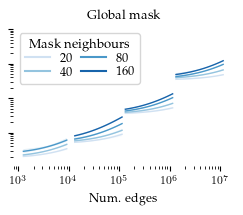

In [8]:
fig = plt.figure(figsize=(base_width, height))
plt.subplots_adjust(0.02 * (1+(15/85)), bottom_padding, 1, title_padding)
gldf = df.query('algorithm=="global_mask"').join(udf, on=id_cols, rsuffix='_umap')
blues = plt.get_cmap('Blues').resampled(6)
n_mask_neighbors = [20, 40, 80, 160]
gldf.apply_time *= 1000
for n in [100, 1000, 10000, 100000]:
    for i, k in enumerate(n_mask_neighbors):
        if k >= n: 
            continue
        sns.regplot(
            gldf.query(f"n_points=={n} & n_mask_neighbors=='{k}'"), 
            x='n_edges_umap', 
            y='apply_time', 
            ci=95, 
            units='repeat', 
            color=blues(i+1), 
            line_kws={'linewidth': 1},
            scatter=False
        )
# xs = np.linspace(1e3, 1e7, 500)
# for a in [5, 50, 500]:
    # plt.plot(xs, [time_range[0] * 1000 + a / 1e7 * x for x in xs], 'k:', linewidth=0.5)
adjust_legend_subtitles(
    plt.legend(
        title='Mask neighbours',
        handles=[
            Line2D([], [], color=blues(i+1), label=k)
            for i, k in enumerate(n_mask_neighbors)
        ],
        ncols=2,
        labelspacing=0.1,
        columnspacing=0.7
    ),
)
plt.title('Global mask')
plt.xlabel('Num. edges')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('')
plt.yticks(yticks)
plt.gca().set_yticklabels(['' for t in yticks])
plt.ylim([t * 1000 for t in time_range])
plt.savefig('./figures/benchmark_global_mask.pdf', pad_inches=0)
plt.show()

Finally, the local mask's `apply time`. The input edge count's effect on the `apply time` is even smaller here, with almost horizontal line segments. The costs of sorting 5 and 40 neighbours do not differ too much, and our parallel implementation's efficiency might improve with increased per-iteration workload, hiding the scaling performance.

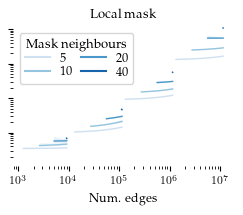

In [9]:
fig = plt.figure(figsize=(base_width, height))
plt.subplots_adjust(0.02 * (1+(15/85)), bottom_padding, 1, title_padding)
gldf = df.query('algorithm=="local_mask"').join(udf, on=id_cols, rsuffix='_umap')
blues = plt.get_cmap('Blues').resampled(6)
n_mask_neighbors = [5, 10, 20, 40]
gldf.apply_time *= 1000
for n in [100, 1000, 10000, 100000]:
    for i, k in enumerate(n_mask_neighbors):
        if k >= n: 
            continue
        sns.regplot(
            gldf.query(f"n_points=={n} & n_mask_neighbors=='{k}'"), 
            x='n_edges_umap', 
            y='apply_time', 
            ci=95, 
            units='repeat', 
            color=blues(i+1), 
            line_kws={'linewidth': 1},
            scatter=False
        )
# xs = np.linspace(1e3, 1e7, 500)
# for a in [5, 50, 500]:
    # plt.plot(xs, [time_range[0] * 1000 + a / 1e7 * x for x in xs], 'k:', linewidth=0.5)
adjust_legend_subtitles(
    plt.legend(
        title='Mask neighbours',
        handles=[
            Line2D([], [], color=blues(i+1), label=k)
            for i, k in enumerate(n_mask_neighbors)
        ],
        ncols=2,
        labelspacing=0.1,
        columnspacing=0.7
    ),
)
plt.title('Local mask')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('')
plt.yticks(yticks)
plt.gca().set_yticklabels(['' for t in yticks])
plt.xlabel('Num. edges')
plt.ylim([t * 1000 for t in time_range])
plt.savefig('./figures/benchmark_local_mask.pdf', pad_inches=0)
plt.show()